In [1]:
%run Functions.ipynb
plt.style.use(["seaborn-dark-palette", "seaborn-whitegrid"])
# https://medium.com/hackernoon/5-minutes-before-funding-fee-33a853f8f9f2 Interesting

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from scipy.stats import norm
import matplotlib.ticker as mtick

pd.set_option('display.max_columns', 500) # premium and funding on btc
pd.set_option('display.max_rows', 500) # premium and funding on btc

In [3]:
def Return_around_funding(df, window_before, window_after, column="close"):
    df["price_before"]  = df[column].shift(window_before)
    df["price_after"]   = df[column].shift(-window_after)
    df["return_around_funding"] = df["price_after"] / df["price_before"] -1
    
    return(df)

In [8]:
def Regr_around_funding(my_df = df_xbt_bitmex, window_before = 0, window_after = 3, magnitude_funding = 0,
                        date_start="2018-07-01", date_end="2021-01-01", column="close", show=False, return_df = False, 
                        hour_start=0, hour_end=24, demeaned=True):
    # Start in 2018 07 due to current funding market structure

    df  =  Return_around_funding(my_df, window_before=window_before, window_after=window_after, column=column)
    df  =  df[(df.index > date_start) & (df.index < date_end)]
    df  = df[(df.index.hour >= hour_start) & (df.index.hour < hour_end)]
    avg_ret = df["log_ret"].mean()
    df = df[abs(df["fundingRate"]) > magnitude_funding]
    df.dropna(subset = ["return_around_funding"], inplace=True)
    df = df[["fundingRate","return_around_funding",column,"price_before","price_after","log_ret"]]
    x = np.array(df["fundingRate"])
    y = np.array(df["return_around_funding"])
    if demeaned:  y = y - avg_ret*window_after #demeaned
    
    my_data = pd.DataFrame({'x':x, 'y':y})    
    results = smf.ols(formula="y ~ x -1", data = my_data).fit() # https://www.statsmodels.org/stable/examples/notebooks/generated/formulas.html
    observ        = results.nobs
    R2            = results.rsquared
    intercept     = 0 #results.params[0]
    pvalue_int    = 0 #results.pvalues[0]
    slope         = results.params[0] #1
    pvalue_slope  = results.pvalues[0] #1
    std_slope     = results.bse[0] #1
    pvalue_slope1 = 2*(1 - norm.cdf(abs(1-slope), scale=std_slope)) 
    asset = my_df["asset"][0]
    exchanger = my_df["exchanger"][0]
    
    test = "%s-%s-%s-%s-%s" % (asset,exchanger,window_before, window_after, magnitude_funding)
    
    if show:
        print (results.summary())
        fig = plt.figure(1, (8,5))
        ax = fig.add_subplot(1,1,1)
        ax.plot(100*x, 100*y, "o", alpha=0.1)
        ax.plot(100*x, 100*x*slope + intercept )
        plt.xlabel("Funding rate"); plt.ylabel("Return")
        plt.axhline(0, linewidth=0.5, color="black"); plt.axvline(0, linewidth=0.5, color="black");
        ax.xaxis.set_major_formatter(mtick.PercentFormatter())
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())

        plt.show()
        
        
        print("__________________________________________________________")
        print("__________________________________________________________")
        print("__________________________________________________________")
        
    res = pd.DataFrame([[observ, R2, intercept, pvalue_int,slope, pvalue_slope, pvalue_slope1, std_slope,window_after, -window_before,magnitude_funding, avg_ret]], index=[test],
                        columns=["observ","R2","intercept","pvalue_int","slope","pvalue_sl=0","pvalue_sl=1","std_sl","window_after","window_before","magnitude_funding","avg_ret"])

    if return_df: return df
    else: return res

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     381.7
Date:                Fri, 11 Sep 2020   Prob (F-statistic):           2.35e-79
Time:                        22:26:31   Log-Likelihood:                 13049.
No. Observations:                2566   AIC:                        -2.610e+04
Df Residuals:                    2565   BIC:                        -2.609e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.2892      0.066     19.537      0.0

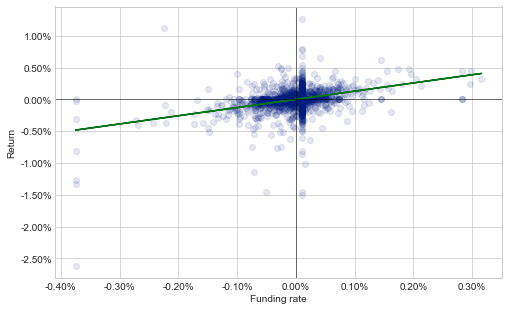

__________________________________________________________
__________________________________________________________
__________________________________________________________


,observ,R2,intercept,pvalue_int,slope,pvalue_sl=0,pvalue_sl=1,std_sl,window_after,window_before,magnitude_funding,avg_ret
XBTUSD-bitmex-0-1-0,2566.0000000,0.1295337,0,0,1.2891778,0.0000000,0.0000117,0.0659863,1,0,0,0.0000008
XBTUSD-bitmex-0-2-0,2566.0000000,0.1009843,0,0,1.5933175,0.0000000,0.0000000,0.0938675,2,0,0,0.0000008
XBTUSD-bitmex-0-3-0,2566.0000000,0.0984058,0,0,1.8008768,0.0000000,0.0000000,0.1076306,3,0,0,0.0000008
XBTUSD-bitmex-0-4-0,2566.0000000,0.0933491,0,0,1.8932692,0.0000000,0.0000000,0.1165021,4,0,0,0.0000008
XBTUSD-bitmex-0-5-0,2566.0000000,0.0849025,0,0,1.8657879,0.0000000,0.0000000,0.1209461,5,0,0,0.0000008


In [255]:
dfs = [df_xbt_bitmex]
df_res = pd.DataFrame()
date_start = "2018-08-01"
date_end = "2021-01-01"
column = "close"
pd.options.display.float_format = '{:.7f}'.format

for df in dfs:
    regrs  = [ # before, after, magnitude, show
              [0, 1, 0, True], 
              [0, 2, 0, False], 
              [0, 3, 0, False],
              [0, 4, 0, False],
              [0, 5, 0, False]
             ]

    for regr in regrs:
        df_res = df_res.append(Regr_around_funding(df, regr[0], regr[1], regr[2], date_start,date_end, column, regr[3]) )
df_res

In [277]:
def regr_plot(df_res=df_res, col1="window_after", col2="slope", col3 = "std_sl", test = 1,
              xlabel="Minutes after funding", ylabel1="Regression slope", col_pval="#8C0900", set_lim = False,MIN=0, MAX=0):
    fig, ax1 = plt.subplots(1,1, figsize=(10,7))
    ax1.plot(df_res[col1], df_res[col2])
    ax1.hlines(test, df_res[col1].min(), df_res[col1].max(), linestyle="dashed", linewidth=1.2, alpha=0.9)
    ax1.fill_between(df_res[col1], df_res[col2]-df_res[col3], df_res[col2]+df_res[col3], alpha=0.2, color="grey")
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1)
    if set_lim: plt.ylim(MIN,MAX)
    plt.show()

## Start of the analysis. Analyzing the whole period

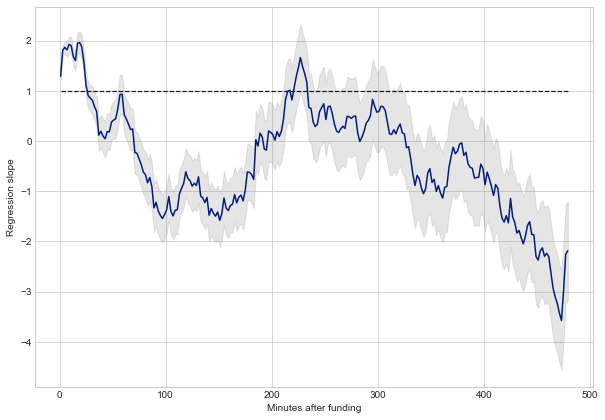

In [258]:
# Short term analysis
df = df_xbt_bitmex # df_xbt_binance, df_eth_binance
df_res = pd.DataFrame()
date_start = "2018-08-01"
date_end   = "2022-08-01"
column     = "close"

i = 1
while i < 60*8:
    df_res = df_res.append(Regr_around_funding(df, 0, i, 0, date_start,date_end, column, False) )
    i = i+2
        
#df_res
regr_plot(df_res=df_res, col1="window_after", col2="slope", col3="std_sl", test=1,
              xlabel="Minutes after funding", ylabel1="Regression slope", col_pval="#8C0900")

0-8

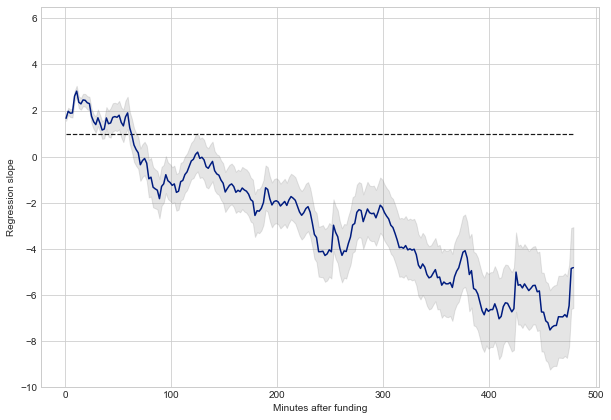

In [279]:
# Short term analysis
df = df_xbt_bitmex # df_xbt_binance, df_eth_binance
df_res = pd.DataFrame()
date_start = "2018-08-01"
date_end   = "2022-08-01"
column     = "close"

i = 1
while i < 60*8:
    df_res = df_res.append(Regr_around_funding(df, 0, i, 0, date_start,date_end, column, False, hour_start=0, hour_end=8) )
    i = i+2
        
#df_res
regr_plot(df_res=df_res, col1="window_after", col2="slope", col3="std_sl", test=1,
              xlabel="Minutes after funding", ylabel1="Regression slope", col_pval="#8C0900",set_lim=True, MIN=-10,MAX=6.5 )

8-16

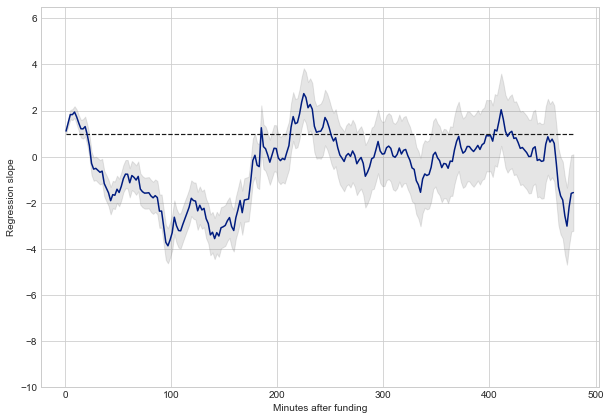

In [280]:
# Short term analysis
df = df_xbt_bitmex # df_xbt_binance, df_eth_binance
df_res = pd.DataFrame()
date_start = "2018-08-01"
date_end   = "2022-08-01"
column     = "close"

i = 1
while i < 60*8:
    df_res = df_res.append(Regr_around_funding(df, 0, i, 0, date_start,date_end, column, False,hour_start=8, hour_end=16) )
    i = i+2
        
#df_res
regr_plot(df_res=df_res, col1="window_after", col2="slope", col3="std_sl", test=1,
              xlabel="Minutes after funding", ylabel1="Regression slope", col_pval="#8C0900",set_lim=True, MIN=-10,MAX=6.5)

16-24

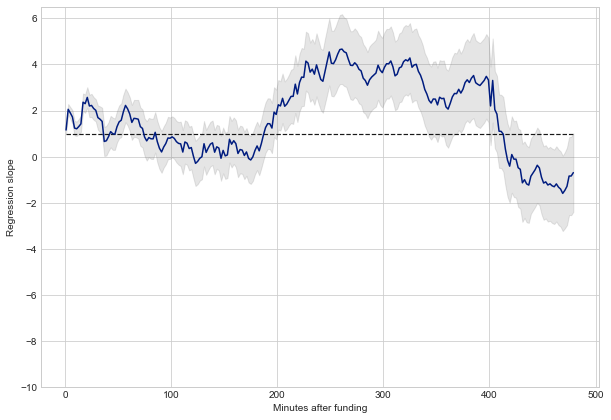

In [281]:
# Short term analysis
df = df_xbt_bitmex # df_xbt_binance, df_eth_binance
df_res = pd.DataFrame()
date_start = "2018-08-01"
date_end   = "2022-08-01"
column     = "close"

i = 1
while i < 60*8:
    df_res = df_res.append(Regr_around_funding(df, 0, i, 0, date_start,date_end, column, False , hour_start=16, hour_end=24) )
    i = i+2
        
#df_res
regr_plot(df_res=df_res, col1="window_after", col2="slope", col3="std_sl", test=1,
              xlabel="Minutes after funding", ylabel1="Regression slope", col_pval="#8C0900",set_lim=True, MIN=-10,MAX=6.5)

### analyze after

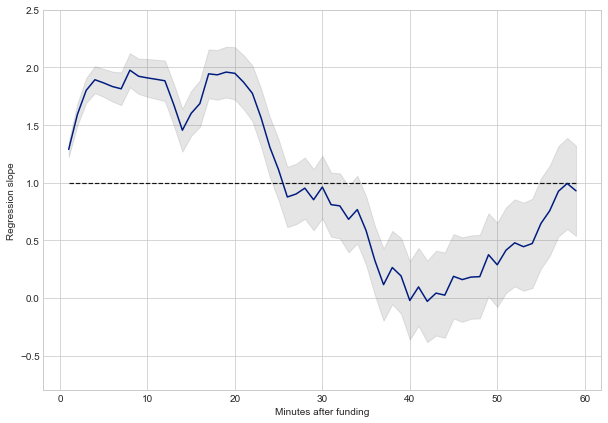

In [285]:
# Short term analysis
df = df_xbt_bitmex # df_xbt_binance, df_eth_binance
df_res = pd.DataFrame()
date_start = "2018-08-01"
date_end   = "2022-08-01"
column     = "close"

i = 1
while i < 60:
    df_res = df_res.append(Regr_around_funding(df, 0, i, 0, date_start,date_end, column, False) )
    i = i+1
        
#df_res

regr_plot(df_res=df_res, col1="window_after", col2="slope", col3="std_sl", test=1,
              xlabel="Minutes after funding", ylabel1="Regression slope", col_pval="#8C0900",set_lim=True, MIN=-0.8,MAX=2.5)

## before 

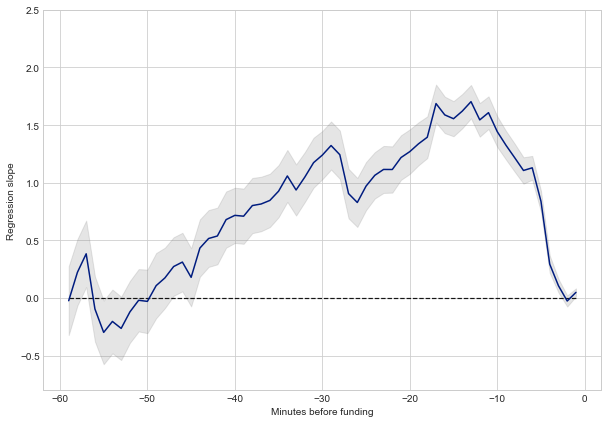

In [283]:
df = df_xbt_bitmex # df_xbt_binance, df_eth_binance
df_res = pd.DataFrame()
date_start = "2018-08-01"
date_end   = "2022-08-01"
column     = "close"

i = 1
while i < 60:
    df_res = df_res.append(Regr_around_funding(df, i, 0, 0, date_start,date_end, column, False) )
    i = i+1
        
#df_res
regr_plot(df_res=df_res, col1="window_before", col2="slope", col3="std_sl", test=0,
              xlabel="Minutes before funding", ylabel1="Regression slope", col_pval="#8C0900", set_lim=True, MIN=-0.8,MAX=2.5)

## On spot price

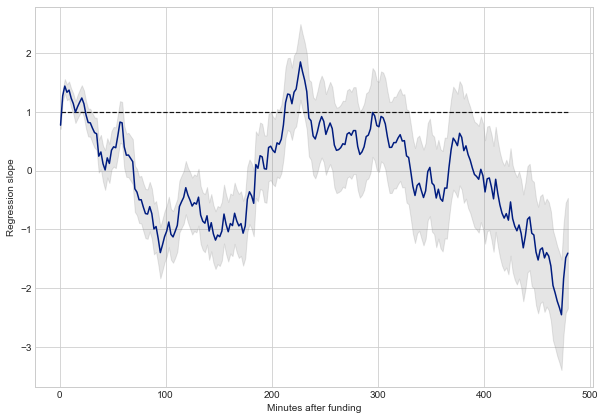

In [264]:
df = df_xbt_bitmex # df_xbt_binance, df_eth_binance
df_res = pd.DataFrame()
date_start = "2018-08-01"
date_end   = "2022-08-01"
column     = "close_ref_binance"

i = 1
while i < 8*60:
    df_res = df_res.append(Regr_around_funding(df, 0, i, 0, date_start,date_end, column, False) )
    i = i+2
        
#df_res

regr_plot(df_res=df_res, col1="window_after", col2="slope", col3="std_sl", test=1,
              xlabel="Minutes after funding", ylabel1="Regression slope", col_pval="#8C0900")

with magnitude

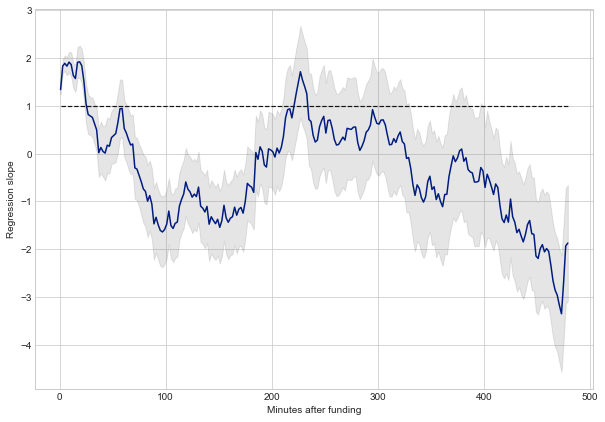

In [265]:
df = df_xbt_bitmex # df_xbt_binance, df_eth_binance
df_res = pd.DataFrame()
date_start = "2018-08-01"
date_end   = "2022-08-01"
column     = "close"

i = 1
while i < 8*60:
    df_res = df_res.append(Regr_around_funding(df, 0, i, 0.03/100, date_start,date_end, column, False) ) # do it with distirbution
    i = i+2
        
#df_res
regr_plot(df_res=df_res, col1="window_after", col2="slope", col3="std_sl", test=1,
              xlabel="Minutes after funding", ylabel1="Regression slope", col_pval="#8C0900")

## Before 2018

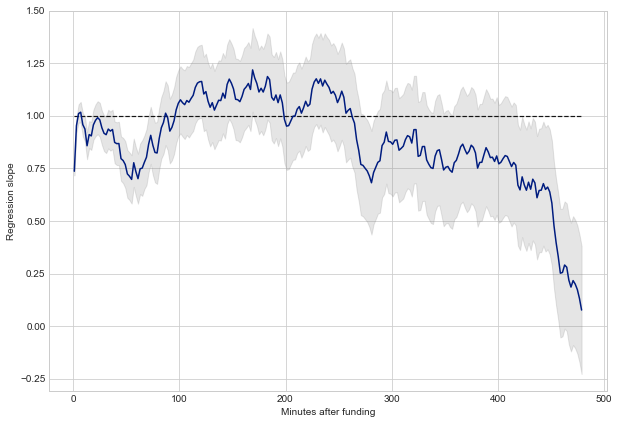

In [273]:
# Short term analysis
df = df_xbt_bitmex # df_xbt_binance, df_eth_binance
df_res = pd.DataFrame()
date_start = "2010-08-01"
date_end   = "2018-08-01"
column     = "close"

i = 1
while i < 60*8:
    df_res = df_res.append(Regr_around_funding(df, 0, i, 0, date_start,date_end, column, False) )
    i = i+2
        
#df_res
regr_plot(df_res=df_res, col1="window_after", col2="slope", col3="std_sl", test=1,
              xlabel="Minutes after funding", ylabel1="Regression slope", col_pval="#8C0900")

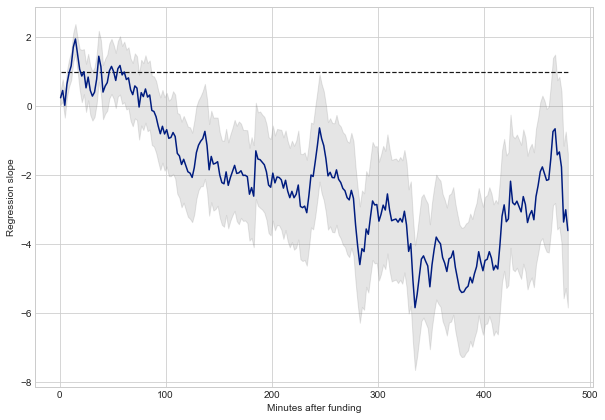

In [266]:
df = df_xbt_binance # df_xbt_binance, df_eth_binance
df_res = pd.DataFrame()
date_start = "2018-08-01"
date_end   = "2028-08-01"
column     = "close"

i = 1
while i < 8*60:
    df_res = df_res.append(Regr_around_funding(df, 0, i, 0, date_start,date_end, column, False) ) # do it with distirbution
    i = i+2
        
#df_res
regr_plot(df_res=df_res, col1="window_after", col2="slope", col3="std_sl", test=1,
              xlabel="Minutes after funding", ylabel1="Regression slope", col_pval="#8C0900")

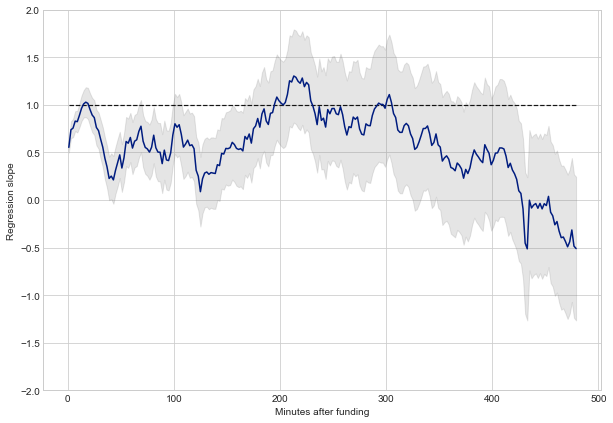

In [286]:
df = df_eth_bitmex # df_xbt_binance, df_eth_binance
df_res = pd.DataFrame()
date_start = "2018-08-01"
date_end   = "2028-08-01"
column     = "close"

i = 1
while i < 8*60:
    df_res = df_res.append(Regr_around_funding(df, 0, i, 0, date_start,date_end, column, False) ) # do it with distirbution
    i = i+2
        
#df_res
regr_plot(df_res=df_res, col1="window_after", col2="slope", col3="std_sl", test=1,
              xlabel="Minutes after funding", ylabel1="Regression slope", col_pval="#8C0900", set_lim=True, MIN=-2,MAX=2)

Spot price - Ether

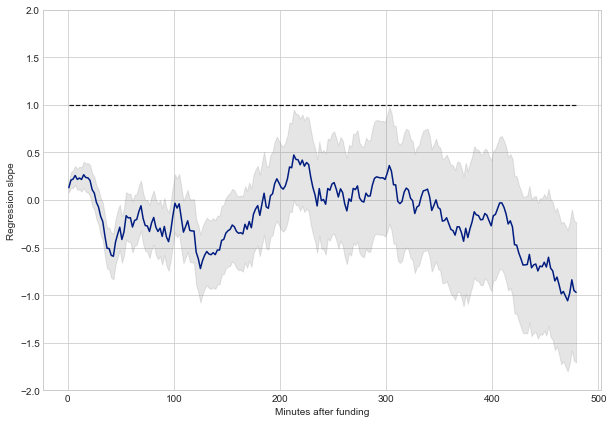

In [287]:
df = df_eth_bitmex # df_xbt_binance, df_eth_binance
df_res = pd.DataFrame()
date_start = "2018-08-01"
date_end   = "2022-08-01"
column     = "close_ref_binance"

i = 1
while i < 8*60:
    df_res = df_res.append(Regr_around_funding(df, 0, i, 0, date_start,date_end, column, False) )
    i = i+2
        
#df_res

regr_plot(df_res=df_res, col1="window_after", col2="slope", col3="std_sl", test=1,
              xlabel="Minutes after funding", ylabel1="Regression slope", col_pval="#8C0900", set_lim=True, MIN=-2,MAX=2)

Peter idea plot

In [269]:
df = df_xbt_bitmex
df["minutehour"] = [str(df.index[i])[11:16] for i in range(len(df))] 
df['log_sum_ret'] = df['log_ret'].groupby(df['minutehour']).transform('sum')
df = df[["log_sum_ret","minutehour"]]

In [270]:
df1  = df[(df.index.hour >= 0) & (df.index.hour < 8)]
df1["demeaned"] = df1["log_sum_ret"] - df1["log_sum_ret"].mean()

df2  = df[(df.index.hour >= 8) & (df.index.hour < 16)]
df2["demeaned"] = df2["log_sum_ret"] - df2["log_sum_ret"].mean()

df3  = df[(df.index.hour >= 16) & (df.index.hour < 24)]
df3["demeaned"] = df3["log_sum_ret"] - df3["log_sum_ret"].mean()

df = df1.append(df2)
df = df.append(df3)
df = df.sort_index()

In [271]:
my_df  = df[(df.index.year == 2018) & (df.index.month == 2)& (df.index.day == 2)]

In [272]:
my_df["cum_log_ret"] = cumulative_return(my_df["demeaned"])

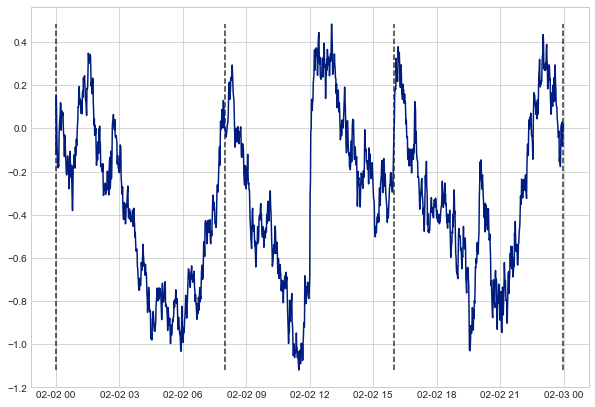

In [250]:
plt.figure(figsize=(10,7))
plt.plot( my_df["cum_log_ret"])
plt.vlines("2018-02-02 00:00:00", ymin=my_df["cum_log_ret"].min(), ymax= my_df["cum_log_ret"].max(), alpha=0.8, linestyle="dashed")
plt.vlines("2018-02-02 08:00:00", ymin=my_df["cum_log_ret"].min(), ymax= my_df["cum_log_ret"].max(), alpha=0.8, linestyle="dashed")
plt.vlines("2018-02-02 16:00:00", ymin=my_df["cum_log_ret"].min(), ymax= my_df["cum_log_ret"].max(), alpha=0.8, linestyle="dashed")
plt.vlines("2018-02-02 23:59:00", ymin=my_df["cum_log_ret"].min(), ymax= my_df["cum_log_ret"].max(), alpha=0.8, linestyle="dashed")

## After the funding

In [15]:
# https://stats.stackexchange.com/questions/160278/testing-for-granger-causality .. how to perform 
# https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781788831192/10/ch10lvl1sec118/granger-causality-test

# all the analysis works with 00:00 = funding and 00:00 = return 00/01

df = Regr_around_funding(my_df = df_xbt_bitmex, window_before = 0, window_after = 60*24, magnitude_funding =0, return_df=True)
df["return_lag"] = df["return_around_funding"].shift(1).dropna() # On the same row I have fundingRate at T and return between T-1 and T
# ... If I move .shift(1) to 0 returns are way more correct...

df.to_csv("granger_data.csv")
 #Now go to R